#HW3 - Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load files, datasets and initial style

In [2]:
from matplotlib import pylab
params = {
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'legend.fontsize': 18,
    'legend.title_fontsize': 22,
    'figure.titlesize': 24
}
pylab.rcParams.update(params)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/לימודים/סמסטר ו/מערכות לומדות/שיעורי בית/Major3/data_HW3.csv')

Mounted at /content/drive


In [4]:
dataset.head()

,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,...,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level
0,733,31,F,80.8,O-,"('11.93381', '79.82979')",6,6,0.7,5,...,5.198138,108.036437,188.801048,4.794950,8.763805,1.664061,10.239285,2.399066,-253.987710,0.327102
1,382,29,F,63.0,O+,"('51.67822', '33.9162')",1,9,NaN,11,...,5.721030,-106.885392,9.936129,1.700335,7.266007,3.071229,5.916312,2.860534,154.620882,0.196443
2,1164,44,F,74.2,O+,"('60.02427', '30.28491')",2,10,1.5,3,...,4.364061,8.145824,46.805718,5.640838,8.647514,3.649969,1.185047,4.834962,106.257677,0.077727
3,897,9,M,31.8,O-,"('51.08468', '7.11393')",3,9,0.5,8,...,0.852508,63.603672,86.119489,8.245630,8.559101,4.537883,0.303430,1.486220,81.953230,0.172861
4,1187,18,F,42.4,A-,"('38.45598', '48.87498')",0,8,0.2,4,...,3.993688,-46.825379,191.552737,6.121042,6.202387,2.250050,8.499374,4.053463,-85.240560,0.367014


In [5]:
def prepare_data(training_data, new_data):
  # make a copy of new_data
  temp_data = new_data.copy()

  # fill null entries in household incomde with the median
  temp_data.household_income = temp_data.household_income.fillna(training_data.household_income.median())

  # create SpecialProperty feature
  if 'SpecialProperty' not in temp_data.columns:
    newGroup1 = temp_data["blood_type"].isin(["O+", "B+"])
    temp_data.insert(2, "SpecialProperty", newGroup1, True)

  # remove bloot type column
  temp_data = temp_data.drop(columns=['patient_id', 'pcr_date', 'current_location', 'blood_type'])

  # scale features according to the train data
  standard_scaler= StandardScaler()
  min_max_scaler = MinMaxScaler(feature_range=(-1,1))
  features_standard = ['PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08']
  features_min_max = ['PCR_03', 'PCR_04', 'PCR_09', 'PCR_10', 'sugar_levels']

  # fit the scalers to the training data statistics
  standard_scaler.fit(training_data[features_standard])
  min_max_scaler.fit(training_data[features_min_max])

  # apply the scalers on the relevant features
  temp_data[features_standard] = standard_scaler.transform(temp_data[features_standard])
  temp_data[features_min_max] = min_max_scaler.transform(temp_data[features_min_max])

  return temp_data

In [6]:
# Split the data to train (80%) and test (20%) parts , two last digits: 49 + 97 = 146
y = dataset[['contamination_level']];
X_dataset = dataset.drop(['contamination_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y, test_size=0.2, random_state=146)

# Apply prepare_data from MajorHW1:
train = prepare_data(X_train, X_train)
test = prepare_data(X_train, X_test)

prepared_train_sec5 = train[['PCR_01','PCR_02', 'PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09','PCR_10', 'sugar_levels']]
prepared_test_sec5 = test[['PCR_01','PCR_02', 'PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09','PCR_10', 'sugar_levels']]

prepared_train = train[['PCR_01','PCR_02', 'PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09','PCR_10']]
prepared_test = test[['PCR_01','PCR_02', 'PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09','PCR_10']]

In [7]:
prepared_train_sec5['sugar_levels'].isna().sum()

0

## Section 1: Linear regression implemantation

In [8]:
# Given LinearRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        #loss = None

        m = X.shape[0]

        # margins are reshaped to have one column: array of shape (n_samples, 1)
        margins = (X.dot(w) + b).reshape(-1, 1)
        error = margins - y.reshape(-1,1)
        loss = np.sum(np.square(error)) / m

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b

        m = X.shape[0]
        # margins are reshaped to have one column: array of shape (n_samples, 1)
        margins = (X.dot(w) + b).reshape(-1, 1)
        error = margins - y.reshape(-1,1)


        #g_w = 2 * np.sum(np.multiply(X, error)) / m
        g_w = 2 * np.dot(X.T, error) / m
        g_w = g_w.reshape(-1)
        g_b = 2 * np.sum(error) / m

        return g_w, g_b



    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)


            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        # The predocator is MLE- maximum likelihood predicator.
        # h(x) is a linear regressor given by h(x)= wX+b
        y_pred = X.dot(self.w) + self.b

        return y_pred

In [9]:
# Given verify_gradients.py

def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()



In [10]:
# given code test_lr.py

import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

In [11]:
# Q1 : spliting the new test set to 80% test subset and 20% validation.
X_trn, X_valid, y_trn, y_valid = train_test_split(prepared_train, y_train, test_size=0.2, random_state=146)
X_trn5, X_valid5, y_trn5, y_valid5 = train_test_split(prepared_train_sec5, y_train, test_size=0.2, random_state=146)

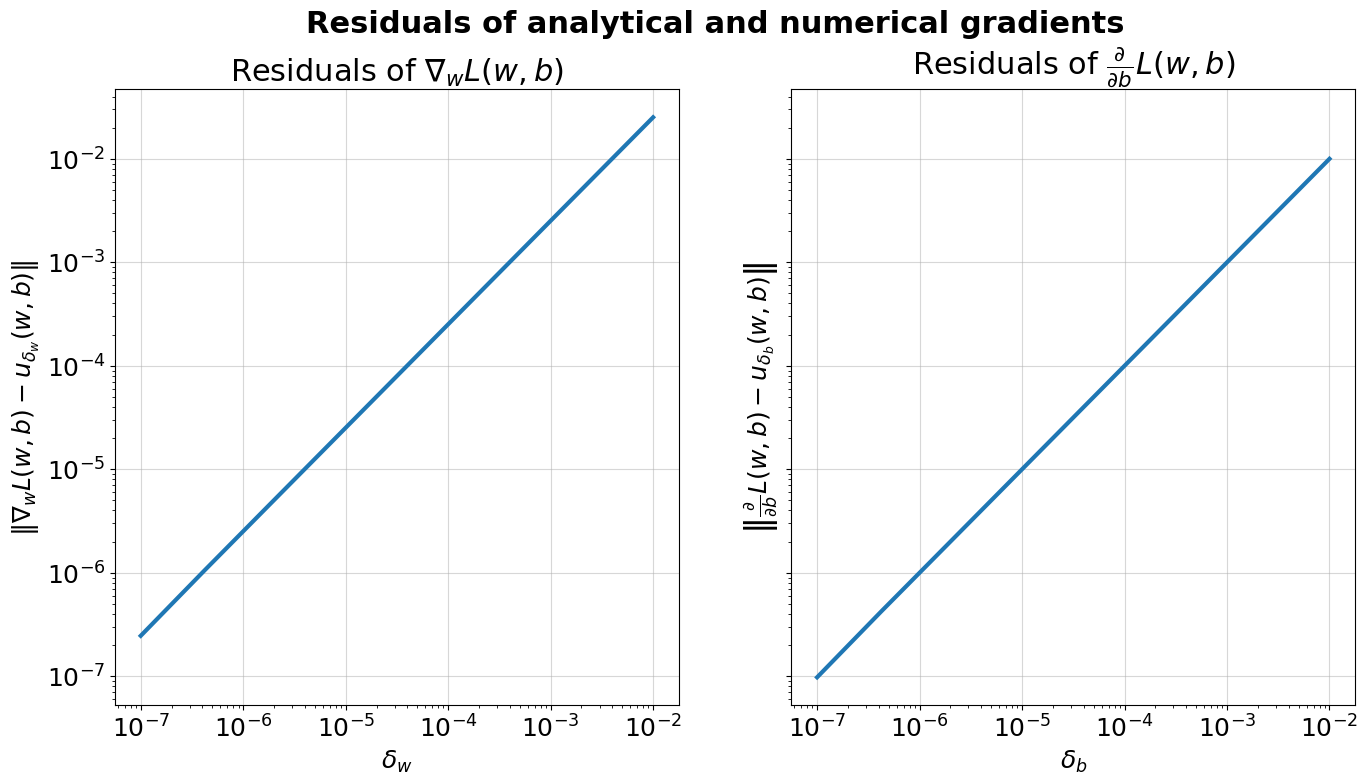

In [12]:
y = np.copy(y_trn)
X = np.copy(X_trn)
compare_gradients(X, y, deltas=np.logspace(-7,-2,9))

lr size = 1e-09, Best train loss = 0.08576701441090889, Best validation loss = 0.06828694003797982
lr size = 1e-08, Best train loss = 0.08576562445779644, Best validation loss = 0.06828569700603751
lr size = 1e-07, Best train loss = 0.08575172797238181, Best validation loss = 0.06827326967772279
lr size = 1e-06, Best train loss = 0.0856130671258898, Best validation loss = 0.06814929493342362
lr size = 1e-05, Best train loss = 0.08425630428042283, Best validation loss = 0.06693883778019188
lr size = 0.0001, Best train loss = 0.07319117983525844, Best validation loss = 0.05727456441166165
lr size = 0.001, Best train loss = 0.038948216939764954, Best validation loss = 0.03093173596224195
lr size = 0.01, Best train loss = 0.024584167736285335, Best validation loss = 0.021264084980452992
lr size = 0.1, Best train loss = 0.02469761160914784, Best validation loss = 0.020978331527219327


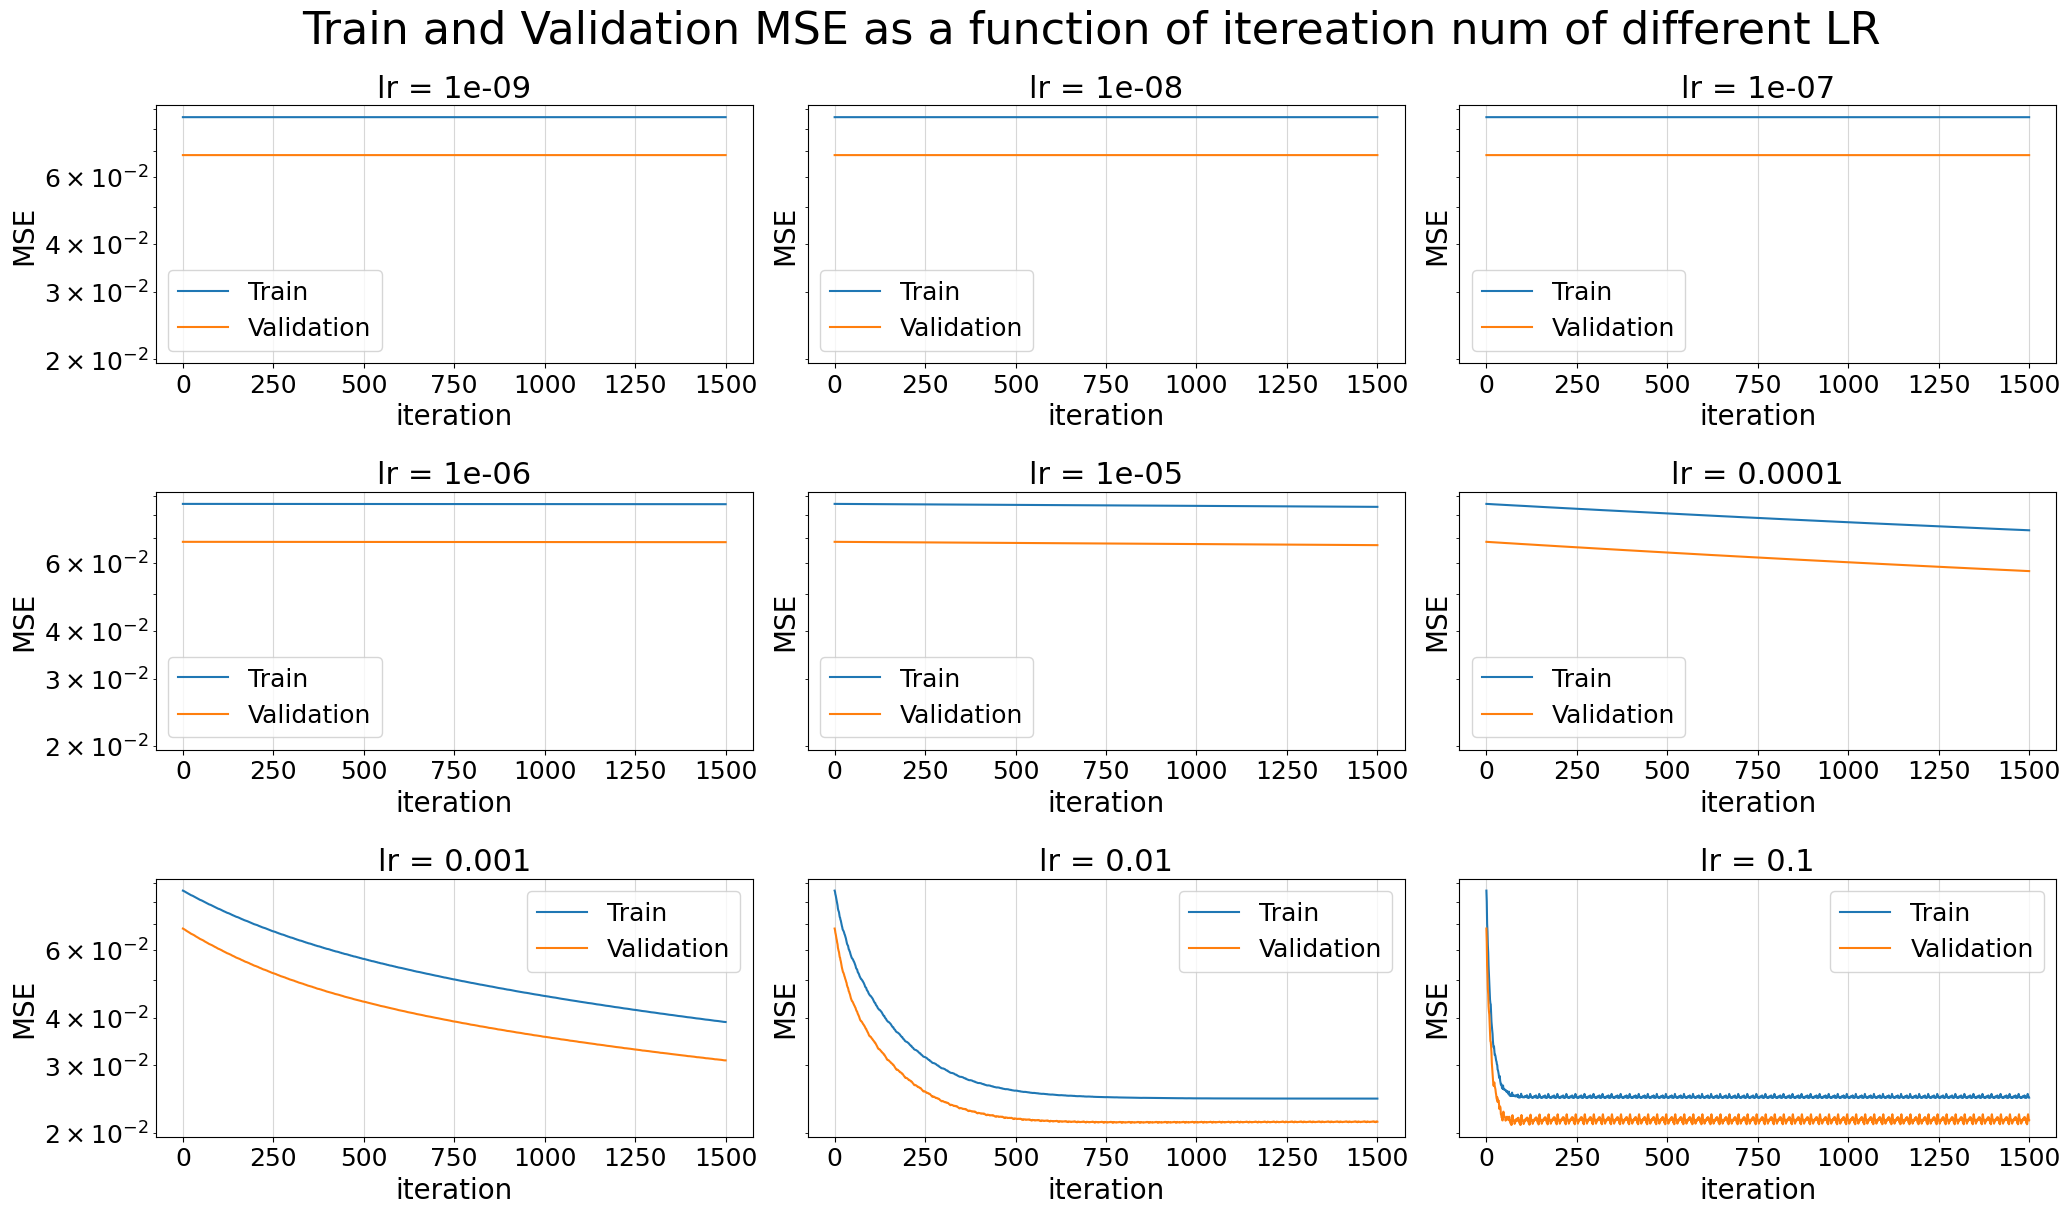

In [13]:
# Q3 : efect of differnt learninig rates
X_val = np.copy(X_valid)
y_val = np.copy(y_valid)
test_lr(X,y,X_val, y_val, 'Train and Validation MSE as a function of itereation num of different LR')

## Section 2 : Evaluation and Baseline

In [14]:
# Q4  Evaluating dummy regressor performance using 5-fold cross validation on the while training set
# dummy always predicts the average contamination_level of the training set.

from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
cv_results = cross_validate(dummy_regr, prepared_train, y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
print(f"Train cross-validated MSE erros:\n{cv_results['train_score']}\n The mean value = {cv_results['train_score'].mean()}\n")
print(f"Test cross-validated MSE erros:\n{cv_results['test_score']}\n The mean value = {cv_results['test_score'].mean()}\n")


Train cross-validated MSE erros:
[-0.06670899 -0.07355978 -0.07040159 -0.0751191  -0.07068514]
 The mean value = -0.0712949205807158

Test cross-validated MSE erros:
[-0.0900277  -0.06264734 -0.07537151 -0.05627169 -0.0739732 ]
 The mean value = -0.07165828897657857



In [15]:
# Q4 task : retraining the dummy regressor on the entire training set (= all its samples) for future use (Sec 6).
dummy_regr.fit(prepared_train, y_train)

DummyRegressor()

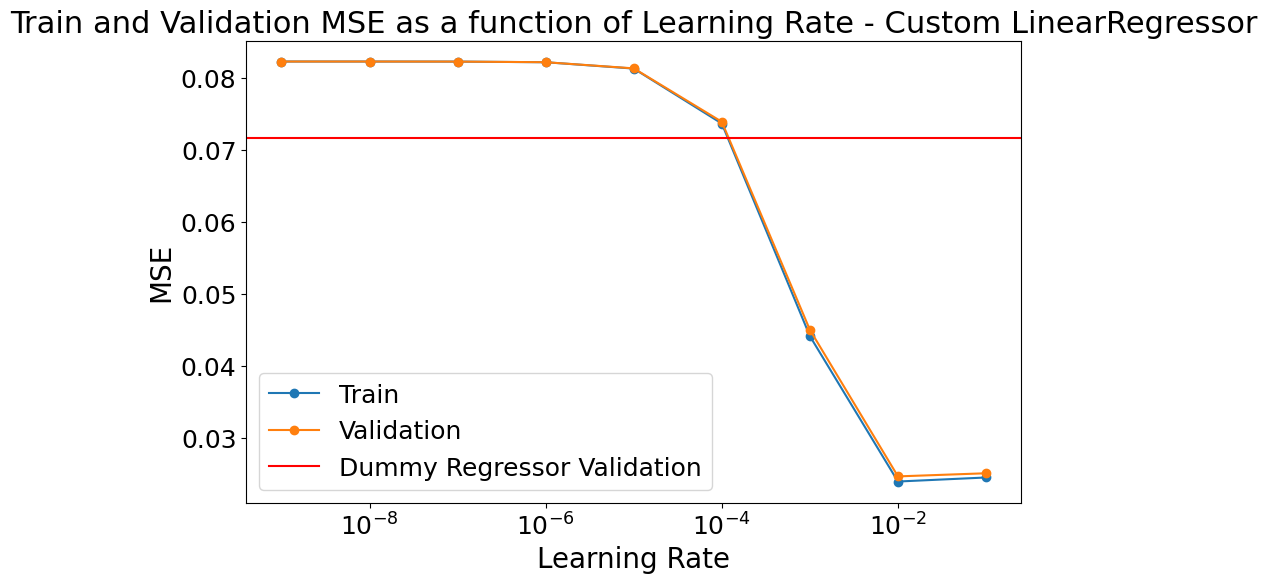

Optimal Learning Rate: 0.01
Validation Error: 0.024602601806949582
Train Error: 0.02388930002514985


In [16]:
# Q5 - evaluate our custim LinearRegressor performance using cross-validation
# First - tunning the LR

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

def tune_learning_rate(X, y, dummy_val_error, max_iter=1000):
    lr_list = np.logspace(-9, -1, 9)
    train_errors = []
    val_errors = []

    for lr in lr_list:
        model = LinearRegressor(lr=lr)

        cv_results = cross_validate(model, X, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')


        train_error = -np.mean(cv_results['train_score'])
        val_error = -np.mean(cv_results['test_score'])


        train_errors.append(train_error)
        val_errors.append(val_error)

    plt.figure(figsize=(10, 6))
    plt.semilogx(lr_list, train_errors,'-o', label='Train')
    plt.semilogx(lr_list, val_errors,'-o', label='Validation')
    plt.axhline(y=-dummy_val_error, color='r',  label='Dummy Regressor Validation')
    plt.xlabel('Learning Rate')
    plt.ylabel('MSE')
    plt.title('Train and Validation MSE as a function of Learning Rate - Custom LinearRegressor')
    plt.legend()
    plt.show()

    best_lr_index = np.argmin(val_errors)
    best_lr = lr_list[best_lr_index]
    best_val_error = val_errors[best_lr_index]
    best_trn_error = train_errors[best_lr_index]

    print(f"Optimal Learning Rate: {best_lr}")
    print(f"Validation Error: {best_val_error}")
    print(f"Train Error: {best_trn_error}")


X = np.copy(prepared_train)
y = np.copy(y_train)
dummy_val_error = cv_results['test_score'].mean()
tune_learning_rate(X, y, dummy_val_error)


In [17]:
# Q6 task - retrain the regressor on the entire training set (= with all its samples) for future use (Sec 6).
custom_LinearRegressor = LinearRegressor(lr=0.01)
custom_LinearRegressor.fit(X, y)

LinearRegressor(lr=0.01)

## Section 3 :  Lasso linear regression

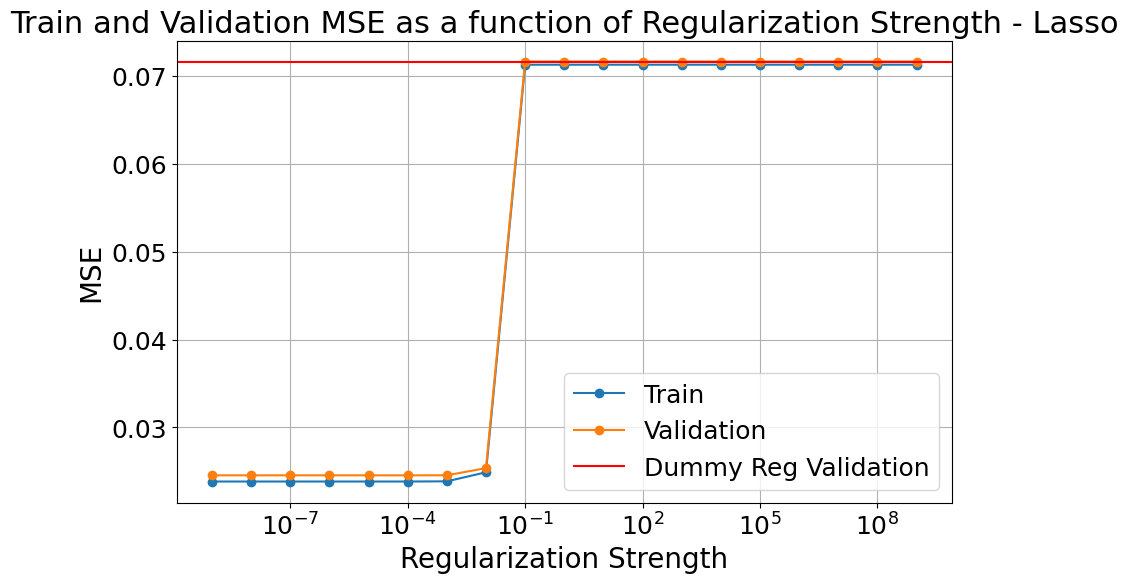

Optimal Regularization Strength (alpha): 0.0001
Validation Error: 0.02453804977770329
Train Error: 0.023834352618536225


In [18]:
# Q7 - tunning the regularization strength of the Lasso regressor.
from sklearn.linear_model import Lasso
def tune_regularization_strength(X, y):
    train_errors = []
    val_errors = []
    #alpha_list = np.logspace(-9, -1, 9)
    #alpha_list = np.logspace(-4, 2, 50)
    alpha_list = np.logspace(-9, 9, 19)


    for alpha in alpha_list:
        model = Lasso(alpha=alpha, fit_intercept=True)

        cv_results = cross_validate(model, X, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

        train_error = -np.mean(cv_results['train_score'])
        val_error = -np.mean(cv_results['test_score'])

        train_errors.append(train_error)
        val_errors.append(val_error)

    plt.figure(figsize=(10, 6))
    plt.semilogx(alpha_list, train_errors,'-o', label='Train')
    plt.semilogx(alpha_list, val_errors,'-o', label='Validation')
    plt.axhline(y=-dummy_val_error, color='r',  label='Dummy Reg Validation')
    plt.xlabel('Regularization Strength')
    plt.ylabel('MSE')
    plt.title('Train and Validation MSE as a function of Regularization Strength - Lasso')
    plt.grid(True)
    plt.legend()
    plt.show()

    best_alpha_index = np.argmin(val_errors)
    best_alpha = alpha_list[best_alpha_index]
    best_val_error = val_errors[best_alpha_index]
    best_trn_error = train_errors[best_alpha_index]

    print(f"Optimal Regularization Strength (alpha): {best_alpha}")
    print(f"Validation Error: {best_val_error}")
    print(f"Train Error: {best_trn_error}")

tune_regularization_strength(X,y)

In [19]:
# Q8 task - : Using the best performing hyperparameter, retrain the regressor on the entire training set for future use (Sec 6)
lasso_regressor = Lasso(alpha=0.0001, fit_intercept=True)
lasso_regressor.fit(X, y)

Lasso(alpha=0.0001)

In [20]:
# Q9 Specify the 5 features having the 5 largest coefficients (in absolute value) in the resulting regressor
coefficients = lasso_regressor.coef_

feature_names = ['PCR_01','PCR_02', 'PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_08','PCR_09','PCR_10']
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# sort the DataFrame by the absolute value of the coefficients
sorted_coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(f"Features with the largest coefficients (in absolute value):\n{sorted_coef_df.head(5)}")


Features with the largest coefficients (in absolute value):
  Feature  Coefficient
3  PCR_04     0.467117
1  PCR_02    -0.080873
5  PCR_06    -0.043937
8  PCR_09    -0.020178
9  PCR_10     0.015542


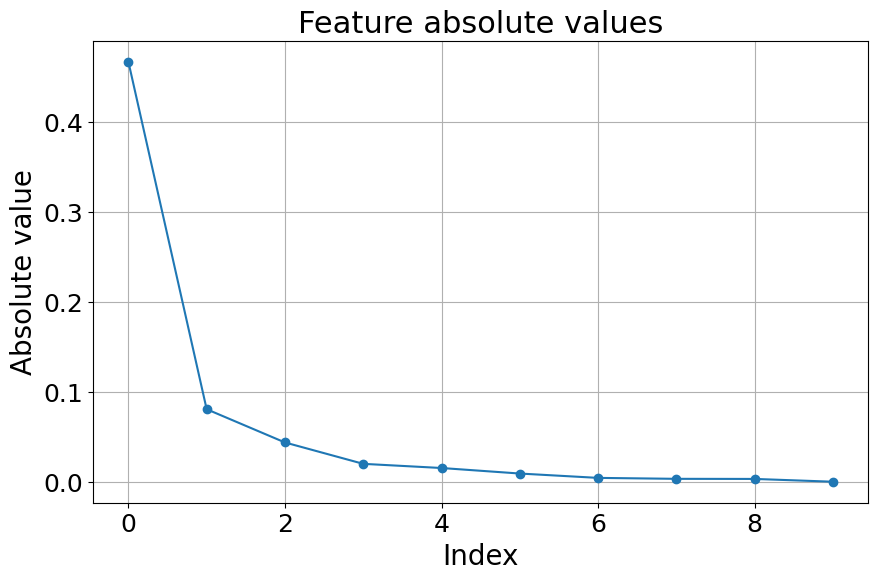

In [21]:
# Q10 # Plot the sorted absolute values of the coefficients

plt.figure(figsize=(10, 6))
plt.plot(sorted_coef_df['Coefficient'].abs().values, '-o')
plt.xlabel('Index')
plt.ylabel('Absolute value')
plt.title('Feature absolute values')
plt.grid(True)
plt.show()


## Section 4 : Polynomial fitting (visualization)

In [22]:
# given plod3d.py
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

<ipython-input-22-960528fe0adf>:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


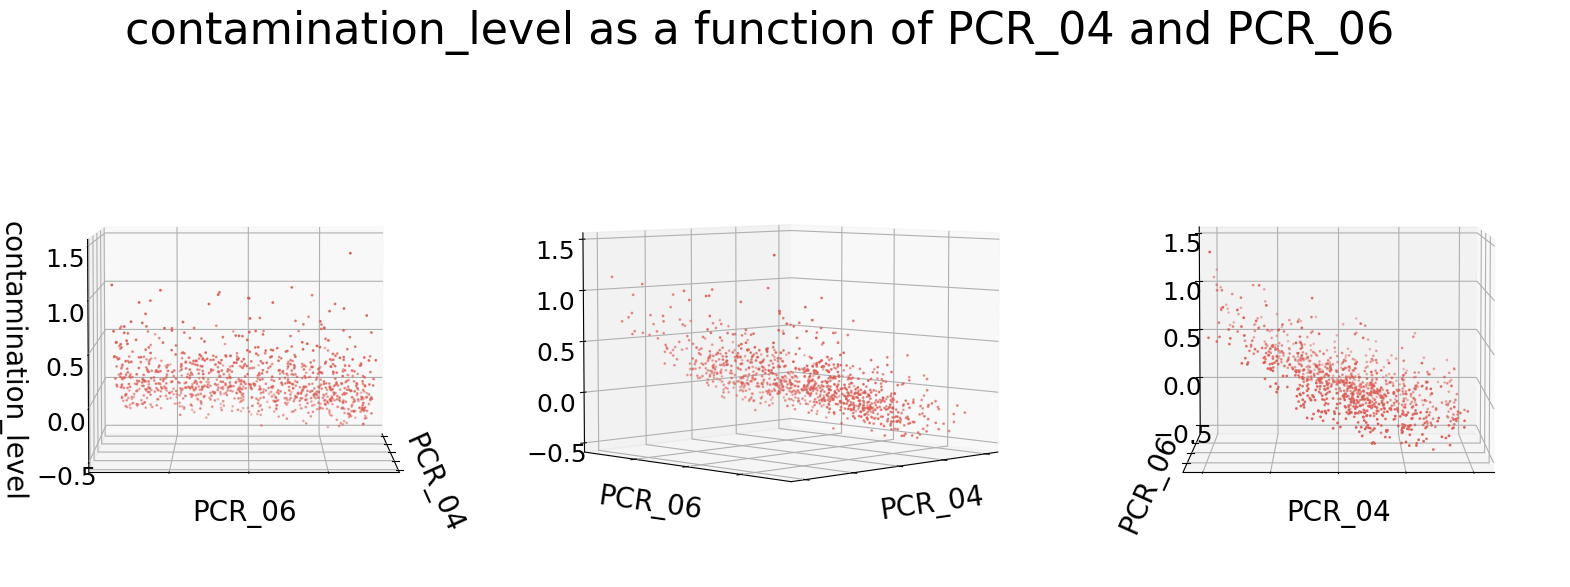

In [23]:
# task : creating train sub set only with PCR_04 and PCR_06
sec4_train = prepared_train[['PCR_04', 'PCR_06']]
result = pd.concat([sec4_train, y_train], axis=1)

plot3d(result, 'PCR_04', 'PCR_06', 'contamination_level', 'contamination_level as a function of PCR_04 and PCR_06')

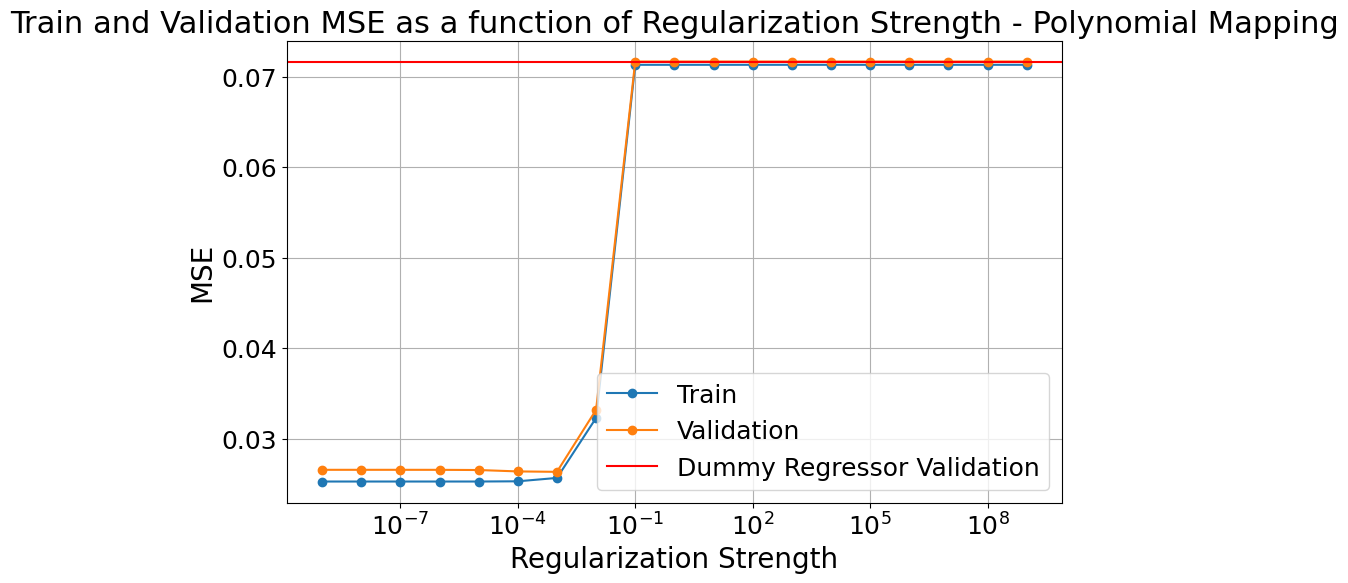

Optimal Regularization Strength (alpha): 0.001
Validation Error: 0.026332360843328784
Train Error: 0.025658676167310036


In [24]:
# Q15 -  tunning the regularization strength of the Lasso regressor with polynomial mapping using cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

def tune_regularization_strength_polynomial_mapping(X, y):
    train_errors = []
    val_errors = []
    alpha_list = np.logspace(-9, 9, 19)
    #alpha_list = np.logspace(-4, 2, 50)

    for alpha in alpha_list:
        poly_reg = Pipeline([('feature_mapping',
                              PolynomialFeatures(degree=4)),
                              ('normalization', MinMaxScaler()),
                                ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])
        cv_results = cross_validate(poly_reg, X, y, cv=5, return_train_score=True, scoring='neg_mean_squared_error')

        train_error = -np.mean(cv_results['train_score'])
        val_error = -np.mean(cv_results['test_score'])

        train_errors.append(train_error)
        val_errors.append(val_error)

    plt.figure(figsize=(10, 6))
    plt.semilogx(alpha_list, train_errors,'o-', label='Train')
    plt.semilogx(alpha_list, val_errors,'o-', label='Validation')
    plt.axhline(y=-dummy_val_error, color='r',  label='Dummy Regressor Validation')
    plt.xlabel('Regularization Strength')
    plt.ylabel('MSE')
    plt.title('Train and Validation MSE as a function of Regularization Strength - Polynomial Mapping')
    plt.grid(True)
    plt.legend()
    plt.show()

    best_alpha_index = np.argmin(val_errors)
    best_alpha = alpha_list[best_alpha_index]
    best_val_error = val_errors[best_alpha_index]
    best_trn_error = train_errors[best_alpha_index]

    print(f"Optimal Regularization Strength (alpha): {best_alpha}")
    print(f"Validation Error: {best_val_error}")
    print(f"Train Error: {best_trn_error}")

sec4_x = np.copy(sec4_train)
tune_regularization_strength_polynomial_mapping(sec4_x,y)

In [25]:
# task : retrain the Lasso regressor on the entire training set - Polymonial mapping
lasso_regressor_poly = Lasso(alpha=0.001, fit_intercept=True)
lasso_regressor_poly.fit(sec4_x, y)


Lasso(alpha=0.001)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
<ipython-input-22-960528fe0adf>:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


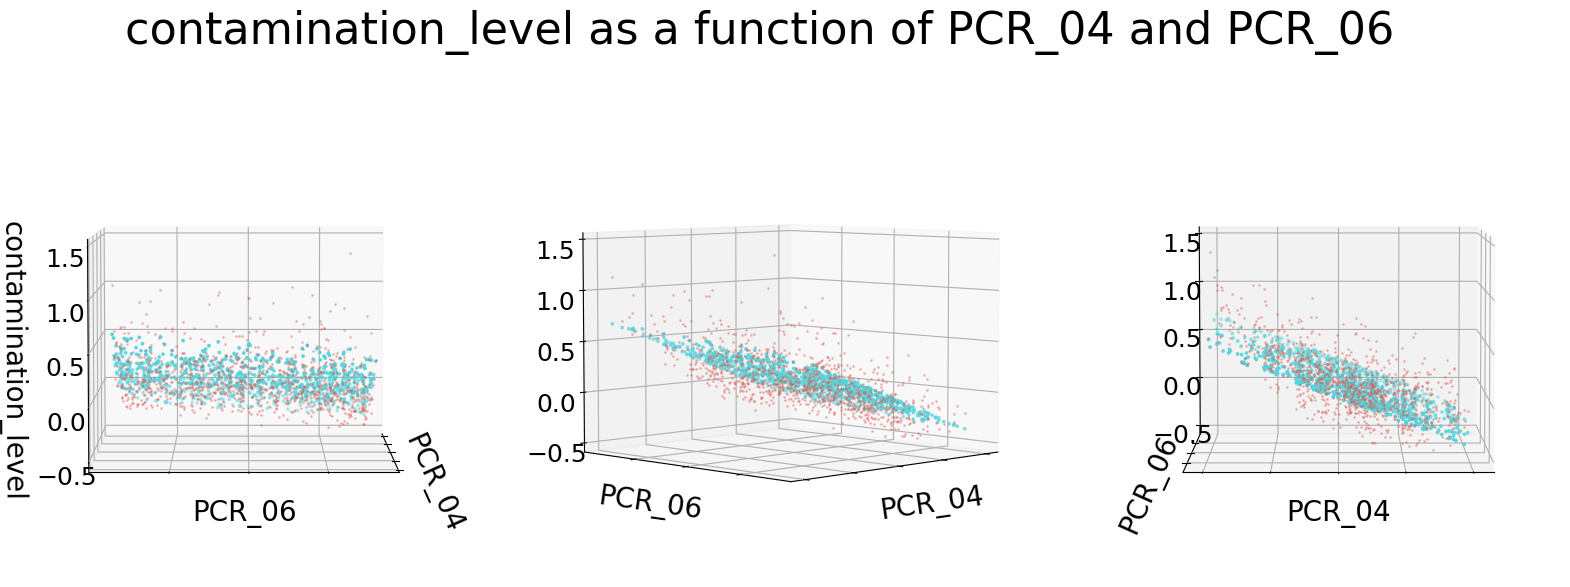

In [26]:
# Q16 : visualize the polynomial model

plot3d(result, 'PCR_04', 'PCR_06', 'contamination_level', 'contamination_level as a function of PCR_04 and PCR_06', lasso_regressor_poly.predict(sec4_train))


## Section 5 : Fitting Gradient Boosted Machines (GBM) of the CovidScore

In [27]:
X5 = np.copy(prepared_train_sec5)
y5 = np.ravel(np.copy(y_train))
y5.shape


(1000,)

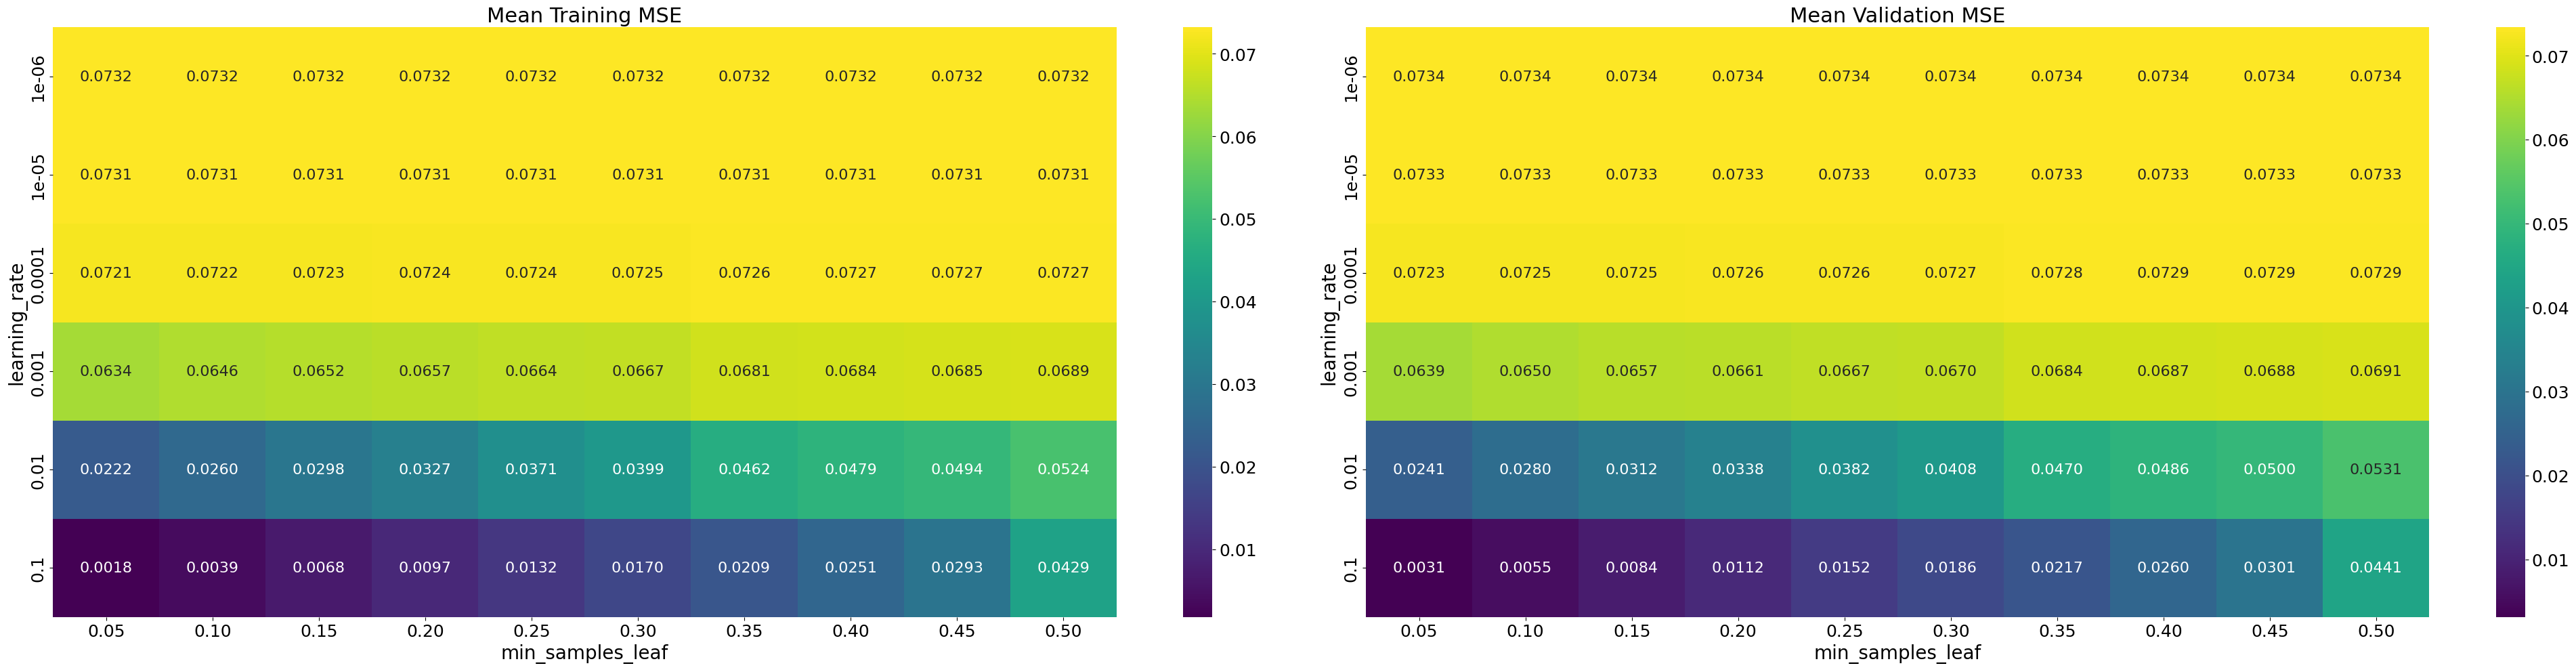

In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# Q18 : Tunning the ‘learning_rate’, and ‘min_samples_leaf’ parameters of the GradientBoostingRegressor model using cross-validation with a grid search

#parameters = {'min_samples_leaf' :(np.linspace(0.05, 0.45, num=9)), 'learning_rate':np.logspace(-9, 9, 19)}
parameters = {
    'GBM__learning_rate': np.logspace(-6, -1, 6),
    'GBM__min_samples_leaf': (np.linspace(0.05, 0.5, num=10))
}

gbm = Pipeline([('normalization', MinMaxScaler()), ('GBM', GradientBoostingRegressor(loss='huber'))])

grid_search = GridSearchCV(estimator=gbm, param_grid=parameters, cv=5, scoring='neg_mean_squared_error',return_train_score=True, n_jobs=-1)

grid_search.fit(X5, y5)

# Convert results into a structured format for visualization
results = grid_search.cv_results_

# Reshape the results to fit into a DataFrame format
mean_train_scores = results['mean_train_score'].reshape(len(parameters['GBM__learning_rate']), len(parameters['GBM__min_samples_leaf']))
mean_test_scores = results['mean_test_score'].reshape(len(parameters['GBM__learning_rate']), len(parameters['GBM__min_samples_leaf']))


# Create DataFrames for seaborn heatmap
train_scores_df = pd.DataFrame(-mean_train_scores, index=parameters['GBM__learning_rate'], columns=parameters['GBM__min_samples_leaf'])
test_scores_df = pd.DataFrame(-mean_test_scores, index=parameters['GBM__learning_rate'], columns=parameters['GBM__min_samples_leaf'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(40, 10))

sns.heatmap(train_scores_df, annot=True, fmt=".4f", cmap='viridis', ax=axes[0],
            xticklabels=[f'{col:.2f}' for col in parameters['GBM__min_samples_leaf']],
            annot_kws={"size": 16})  # increase font size for annotations)
axes[0].set_title('Mean Training MSE')
axes[0].set_xlabel('min_samples_leaf')
axes[0].set_ylabel('learning_rate')

sns.heatmap(test_scores_df, annot=True, fmt=".4f", cmap='viridis', ax=axes[1],
            xticklabels=[f'{col:.2f}' for col in parameters['GBM__min_samples_leaf']],
            annot_kws={"size": 16})  # increase font size for annotations)
axes[1].set_title('Mean Validation MSE')
axes[1].set_xlabel('min_samples_leaf')
axes[1].set_ylabel('learning_rate')

plt.tight_layout()
plt.show()


In [29]:
# print the best parameters

#best_params = grid_search.best_params_
#best_learning_rate = best_params['GBM__learning_rate']
#best_min_samples_leaf = best_params['GBM__min_samples_leaf']

best_train_error = train_scores_df.loc[0.01, 0.05]
best_validation_error = test_scores_df.loc[0.01, 0.05]

#print(f"Best parameters found: {best_params}")
print(f"Best Train Error: {best_train_error:}")
print(f"Best Validation Error: {best_validation_error:}")

Best Train Error: 0.02216355423422791
Best Validation Error: 0.02412640336497494


In [30]:
# Task: Train the GBM regressor on the entire training set and save it for future use (Sec 6)
gbm_reg = GradientBoostingRegressor(loss='huber', learning_rate=0.01, min_samples_leaf=0.05)
gbm_reg.fit(X5, y5)

GradientBoostingRegressor(learning_rate=0.01, loss='huber',
                          min_samples_leaf=0.05)

## Section 6: Testing your models

In [31]:
from sklearn.metrics import mean_squared_error
# Q20 : test the models
# אשר אנו מבצעים פרדיקציה של המודלים אנחנו צריכים בכל מודל להשתמש רק בתכונות המקוריות שעליהם אימנו אותו

# Dummy
dummy_prediction = dummy_regr.predict(prepared_test)
dummy_test_mse = mean_squared_error(y_test, dummy_prediction)
print(f"Dummy Test MSE: {dummy_test_mse}")

# Linear
linear_prediction = custom_LinearRegressor.predict(prepared_test)
linear_test_mse = mean_squared_error(y_test, linear_prediction)
print(f"Linear Test MSE: {linear_test_mse}")

# Linear Lasso
linear_lasso_prediction = lasso_regressor.predict(np.copy(prepared_test))
linear_lasso_test_mse = mean_squared_error(y_test, linear_lasso_prediction)
print(f"Linear Lasso Test MSE: {linear_lasso_test_mse}")

# Polynomial Lasso
test_ = np.copy(prepared_test[['PCR_04', 'PCR_06']])
polynomial_lasso_prediction = lasso_regressor_poly.predict(test_)
polynomial_lasso_test_mse = mean_squared_error(y_test, polynomial_lasso_prediction)
print(f"Polynomial Lasso Test MSE: {polynomial_lasso_test_mse}")

# Gradient Boosted - GBM
gbm_prediction = gbm_reg.predict(np.copy(prepared_test_sec5))
gbm_test_mse = mean_squared_error(y_test, gbm_prediction)
print(f"GBM Test MSE: {gbm_test_mse}")


Dummy Test MSE: 0.05582772158839282
Linear Test MSE: 0.02462522597776613
Linear Lasso Test MSE: 0.024529052086867103
Polynomial Lasso Test MSE: 0.026686267183952915
GBM Test MSE: 0.018962832765696276
